In [1]:
import pandas as pd
import numpy as np
from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import AllChem
import time
import random
import os
from os.path import join
from cd_clustering import *
from bioservices import *
import chemparse

## 1. Mapping all substrate to substrate classes:

#### (a) Loading Transporter dataset:

In [31]:
df_transporter = pd.read_pickle(join("..", "..", "data",  "Transporter_merged.pkl"))
df_transporter

,Sequence,ChEBI,GOA,TCDB,SWISS,Uniprot ID
0,AAIFFAGTPILESAMVYPLAICGACILTSIAGTFFVKLGTNNSIMG...,CHEBI:15378,0.0,0.0,1.0,Q93AS1
1,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,CHEBI:3659,1.0,0.0,0.0,P22687
2,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,CHEBI:41509,0.0,0.0,1.0,P22687
3,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,CHEBI:46898,0.0,0.0,1.0,P22687
4,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,CHEBI:53753,0.0,0.0,1.0,P22687
...,...,...,...,...,...,...
18001,XDPDCQSLCFEVYPETARHGSCITNVNGEPLKEKTQNSCMEESPTA...,CHEBI:22984,1.0,0.0,0.0,F6RT95
18002,XSGKVLSEEEKAAANVYIKKME,CHEBI:15378,0.0,0.0,1.0,P80730
18003,XSNATDETXLKDVSA,CHEBI:15378,0.0,0.0,1.0,P80263
18004,XYARQMMFSTTLLIVFFTVWVFGGGTTAMLSCLHIRYYARLWGYRD...,CHEBI:15378,1.0,0.0,0.0,A0A140LJ55


#### (b) Creating a DataFrame with all substrates

In [7]:
df_substrate = pd.DataFrame(data = {"ChEBI" : df_transporter["ChEBI"]})
df_substrate.drop_duplicates(inplace = True)
df_substrate.reset_index(inplace = True, drop = True)
df_substrate["anion"], df_substrate["cation"], df_substrate["sugar"] =  0,0,0
df_substrate["amino acid"],df_substrate["protein"], df_substrate["electron"] = 0,0,0
df_substrate.to_pickle(join("..", "..", "data", "substrates", "all_ChEBIs.pkl"))
df_substrate

,ChEBI,anion,cation,sugar,amino acid,protein,electron
0,CHEBI:15378,0,0,0,0,0,0
1,CHEBI:3473,0,0,0,0,0,0
2,CHEBI:25367,0,0,0,0,0,0
3,CHEBI:3659,0,0,0,0,0,0
4,CHEBI:41509,0,0,0,0,0,0
...,...,...,...,...,...,...,...
1865,CHEBI:6953,0,0,0,0,0,0
1866,CHEBI:32379,0,0,0,0,0,0
1867,CHEBI:17992,0,0,0,0,0,0
1868,CHEBI:355715,0,0,0,0,0,0


#### (c) Mapping CHEBI IDs to names, formulas, and to substrate classes:

In [8]:
def get_parent_names(res):
    parents = res.OntologyParents
    parent_names = []
    for parent in parents:
        if parent.type == "is a":
            parent_names.append(parent.chebiName)
    return(parent_names)

def get_parent_type(parent_name):
    classes = []
    if "cation" in parent_name.lower():
        classes.append("cation")
    if "anion" in parent_name.lower():
        classes.append("anion")
    if ("sugar" in parent_name.lower() or "monosaccharide" in parent_name.lower() or
          "disaccharide" in parent_name.lower() or "polysaccharide" in parent_name.lower()):
        classes.append("sugar")
    if ("amino acid" in parent_name.lower() or "oligopeptide" in parent_name.lower() or
          "dipeptide" in parent_name.lower()):
        classes.append("amino acid")
    if "protein" in parent_name.lower() or "mrna" in  parent_name.lower():
        classes.append("protein")
    if "electron" in parent_name.lower():
        classes.append("electron")
    return(classes)
    
    
def get_type_of_substrate(parent_names):
    classes = []
    for parent_name in parent_names:
        classes = classes + get_parent_type(parent_name = parent_name)
    return(list(set(classes)))

In [ ]:
ch = ChEBI()

df_substrate["type"] = ""
df_substrate["Substrate"] = ""
df_substrate["InChI"] = ""
df_substrate["formula"] = ""

for ind in df_substrate.index:
    print(ind)
    try:
        res = ch.getCompleteEntity(df_substrate["ChEBI"][ind])
        
        try: df_substrate["Substrate"][ind] = res.chebiAsciiName
        except: pass
        
        try: 
            classes = get_type_of_substrate(parent_names = get_parent_names(res = res))
            for c in classes:
                df_substrate[c][ind] = 1
        except: pass
        
        try: df_substrate["InChI"][ind] = res.inchi
        except: pass
        
        try: df_substrate["formula"][ind] = res.Formulae[0]["data"]
        except: pass
            
    except:
        pass

0
1


C:\Users\alexk\anaconda3\envs\Predicting_Km\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\alexk\anaconda3\envs\Predicting_Km\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\alexk\anaconda3\envs\Predicting_Km\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\alexk\anaconda3\

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62


In [ ]:
df_substrate

In [10]:
df_substrate.to_csv(join("..", "..", "data", "substrates", "all_ChEBIs_with_categories.csv"), index = False, sep = ";")

In [8]:
df_substrate_old = pd.read_csv(join("C:\\Users\\alexk\\projects\\Transporter_model\\data\\substrates",
                                    "all_ChEBIs_with_categories_curated.csv"), sep = ";")

In [26]:
df_substrate.head()

,ChEBI,anion,cation,sugar,amino acid,protein,electron,type,Substrate,InChI,formula
0,CHEBI:15378,0,1,0,0,0,0,NaN,hydron,InChI=1S/p+1,H
1,CHEBI:3473,0,0,0,0,0,0,NaN,cation,NaN,
2,CHEBI:25367,0,0,0,0,0,0,NaN,molecule,NaN,
3,CHEBI:3659,0,0,0,0,0,0,NaN,cholesterol,InChI=1S/C27H46O/c1-18(2)7-6-8-19(3)23-11-12-2...,C27H46O
4,CHEBI:41509,0,0,0,0,0,0,NaN,cholesteryl linoleate,InChI=1S/C45H76O2/c1-7-8-9-10-11-12-13-14-15-1...,C45H76O2


In [27]:
old_CHEBIs = df_substrate_old["ChEBI"]

In [28]:
categories = ["anion", "cation", "sugar", "amino acid" , "protein", "electron"]

for ind in df_substrate.index:
    chebi = df_substrate["ChEBI"][ind]
    if chebi in old_CHEBIs:
        ind2 = list(df_substrate_old.loc[df_substrate_old["ChEBI"] == chebi].index)[0]
        
        for categorie in categories:
            df_substrate[categorie][ind] = df_substrate_old[categorie][ind2]

In [3]:
df_substrate = pd.read_csv(join("..", "..", "data", "substrates", "all_ChEBIs_with_categories_curated.csv"), sep = ";")

In [4]:
df_substrate["formula"].loc[pd.isnull(df_substrate["formula"])] = ""
df_substrate["Substrate"].loc[pd.isnull(df_substrate["Substrate"])] = ""

C:\Users\alexk\anaconda3\envs\Predicting_Km\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


##### c(i) If substrate names end with "ose" and if they only contain C, H, and O atoms, we mark them as sugars:

In [5]:
def remove_charge(sub):
    if len(sub) < 4:
        return(sub)
    if sub[-4] == "(":
        return(sub[:-4])
    else:
        return(sub)

def check_for_sugar(formula, sub_name):
    formula_dict = chemparse.parse_formula(formula)
    composition =  (set(list(formula_dict.keys())) == set(["C", "H", "O"]))
    sub_name = remove_charge(sub_name)
    if sub_name[-3:] == "ose" and composition:
        return(True)
    return(False)

def check_for_sugar_composition(formula):
    formula_dict = chemparse.parse_formula(formula)
    return(set(list(formula_dict.keys())) == set(["C", "H", "O"]))

In [6]:
for ind in df_substrate.index:
    if check_for_sugar(formula = df_substrate["formula"][ind], sub_name = df_substrate["Substrate"][ind]):
        df_substrate["sugar"][ind] = 1
        
    if df_substrate["sugar"][ind] == 1:
        if not check_for_sugar_composition(formula = df_substrate["formula"][ind]):
            df_substrate["sugar"][ind] = 0

C:\Users\alexk\anaconda3\envs\Predicting_Km\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\alexk\anaconda3\envs\Predicting_Km\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


##### (c)(ii) If molecule is labeled as anion or cation, but contains "C" atoms, we remove the label:

In [7]:
for ind in df_substrate.index:
    if df_substrate["anion"][ind] == 1 or df_substrate["cation"][ind] == 1:
        formula_dict = chemparse.parse_formula(df_substrate["formula"][ind])
        if "C" in list(formula_dict.keys()):
            df_substrate["anion"][ind] = 0
            df_substrate["cation"][ind] = 0

C:\Users\alexk\anaconda3\envs\Predicting_Km\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\alexk\anaconda3\envs\Predicting_Km\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
df_substrate

,ChEBI,anion,cation,sugar,amino acid,protein,electron,other,type,Substrate,InChI,formula
0,CHEBI:3731,1,0,0,0,0,0,0,NaN,chloride,InChI=1S/ClH/h1H/p-1,Cl
1,CHEBI:5605,1,0,0,0,0,0,0,NaN,halide anion,NaN,X
2,CHEBI:9744,1,0,0,0,0,0,0,NaN,triphosphate(5-),"InChI=1S/H5O10P3/c1-11(2,3)9-13(7,8)10-12(4,5)...",O10P3
3,CHEBI:30811,1,0,0,0,0,0,0,NaN,tetrachloroferrate(1-),InChI=1S/4ClH.Fe/h4*1H;/q;;;;+3/p-4,Cl4Fe
4,CHEBI:3178,1,0,0,0,0,0,0,NaN,bromide,InChI=1S/BrH/h1H/p-1,Br
...,...,...,...,...,...,...,...,...,...,...,...,...
1865,CHEBI:41872,0,0,0,0,0,0,1,NaN,dequalinium,InChI=1S/C30H38N4/c1-23-21-27(31)25-15-9-11-17...,C30H40N4
1866,CHEBI:6953,0,0,0,0,0,0,1,NaN,mitomycin C,InChI=1S/C15H18N4O5/c1-5-9(16)12(21)8-6(4-24-1...,C15H18N4O5
1867,CHEBI:32379,0,0,0,0,0,0,1,NaN,"cis,cis-muconate","InChI=1S/C6H6O4/c7-5(8)3-1-2-4-6(9)10/h1-4H,(H...",C6H4O4
1868,CHEBI:355715,0,0,0,0,0,0,1,NaN,4-nitrophenyl-beta-D-galactoside,InChI=1S/C12H15NO8/c14-5-8-9(15)10(16)11(17)12...,C12H15NO8


In [9]:
df_substrate["electron"].loc[df_substrate["Substrate"] == "electron"] = 1

C:\Users\alexk\anaconda3\envs\Predicting_Km\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [10]:
categories = ["cation", "anion", "sugar", "amino acid", "protein", "electron"]

for categorie in categories:
    print("%s : %s"  % (categorie, sum(df_substrate[categorie])))

cation : 85
anion : 53
sugar : 77
amino acid : 163
protein : 10
electron : 2


##### (c)(iii) We set categorie "other" for molecules that do not fit in one of the above categories:

We only consider substrates where we were able to get the substrate name and the chemical formula in order to prevent misclassifications:

In [38]:
df_substrate["other"] = 0
for ind in df_substrate.index:
    if sum(df_substrate[categories].loc[ind]) == 0:
        if (not pd.isnull(df_substrate["InChI"][ind]) and 
            df_substrate["formula"][ind] != "" and df_substrate["Substrate"][ind] != ""):
            df_substrate["other"][ind] = 1

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [39]:
categories = ["cation", "anion", "sugar", "amino acid", "protein", "electron", "other"]

for categorie in categories:
    print("%s : %s"  % (categorie, sum(df_substrate[categorie])))

cation : 78
anion : 54
sugar : 79
amino acid : 153
protein : 56
electron : 1
other : 1032


In [41]:
df_substrate.to_csv(join("..", "..", "data", "substrates", "all_ChEBIs_with_categories.csv"), index = False, sep = ";")

In [46]:
all_chebis = list(set(df_transporter["ChEBI"]))
len(all_chebis), len(df_substrate.loc[df_substrate["ChEBI"].isin(all_chebis)].loc[pd.isnull(df_substrate["InChI"])])

(509, 83)

## 2. Mapping the substrate classes to the Transporters:

We manually reviewed the mapping of ChEBI IDs to the seven classes to find and correct misclassifications

In [2]:
df_substrate = pd.read_csv(join("..", "..", "data", "substrates", "all_ChEBIs_with_categories_curated.csv"), sep = ";")
df_substrate = df_substrate.loc[df_substrate["ChEBI"].isin(all_chebis)]

NameError: name 'all_chebis' is not defined

In [4]:
categories = ["cation", "anion", "sugar", "amino acid", "protein", "electron", "other"]
for c in categories:
    print(c, np.sum(df_substrate[c]))

cation 87
anion 59
sugar 92
amino acid 163
protein 10
electron 2
other 945


In [54]:
categories = ["cation", "anion", "sugar", "amino acid", "protein", "electron", "other"]

total = 0

for categorie in categories:
    print("%s : %s"  % (categorie, sum(df_substrate[categorie])))
    total += sum(df_substrate[categorie])
print("total: ", total)

cation : 26
anion : 25
sugar : 33
amino acid : 80
protein : 3
electron : 1
other : 255
total:  423


In [5]:
df_substrate["No found type"] = 0

for ind in df_substrate.index:
    if sum(df_substrate[categories].loc[ind]) == 0:
        df_substrate["No found type"][ind] = 1

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


#### (a) Creating a DataFrame with all unique sequences:

In [6]:
df_model_input = pd.DataFrame(data = {"Sequence" : df_transporter["Sequence"]})
df_model_input.drop_duplicates(inplace = True)
df_model_input.reset_index(inplace = True, drop = True)
df_model_input

,Sequence
0,AAIFFAGTPILESAMVYPLAICGACILTSIAGTFFVKLGTNNSIMG...
1,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...
2,ADNQHPTVYQKVASQMHLSSSLSQDVHARYGGIQRPALSQRRFPYG...
3,AEKLEPVLPLIV
4,AEVLMDFPQLTMTLPDGREESVMKLTTLVA
...,...
13772,XDPDCQSLCFEVYPETARHGSCITNVNGEPLKEKTQNSCMEESPTA...
13773,XSGKVLSEEEKAAANVYIKKME
13774,XSNATDETXLKDVSA
13775,XYARQMMFSTTLLIVFFTVWVFGGGTTAMLSCLHIRYYARLWGYRD...


#### (b) Mapping substrate classes to transporters:

In [7]:
categories = ["cation", "anion", "sugar", "amino acid", "protein", "electron", "other", "No found type"]

In [8]:
for categorie in categories:
    df_model_input[categorie] = 0

for ind in df_model_input.index:
    seq = df_model_input["Sequence"][ind]
    substrates = list(df_transporter["ChEBI"].loc[df_transporter["Sequence"] == seq])

    for categorie in categories:
        df_model_input[categorie][ind] = max(df_substrate[categorie].loc[df_substrate["ChEBI"].isin(substrates)])
df_model_input

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Sequence,cation,anion,sugar,amino acid,protein,electron,other,No found type
0,AAIFFAGTPILESAMVYPLAICGACILTSIAGTFFVKLGTNNSIMG...,1,0,0,0,0,0,0,0
1,ACPKGASYEAGIVCRITKPALLVLNQETAKVVQTAFQRAGYPDVSG...,0,0,0,0,0,0,1,1
2,ADNQHPTVYQKVASQMHLSSSLSQDVHARYGGIQRPALSQRRFPYG...,0,0,0,0,0,0,1,0
3,AEKLEPVLPLIV,1,0,0,0,0,0,0,0
4,AEVLMDFPQLTMTLPDGREESVMKLTTLVA,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
13772,XDPDCQSLCFEVYPETARHGSCITNVNGEPLKEKTQNSCMEESPTA...,0,0,0,0,0,0,1,0
13773,XSGKVLSEEEKAAANVYIKKME,1,0,0,0,0,0,0,0
13774,XSNATDETXLKDVSA,1,0,0,0,0,0,0,0
13775,XYARQMMFSTTLLIVFFTVWVFGGGTTAMLSCLHIRYYARLWGYRD...,1,0,0,0,0,0,0,0


In [9]:
categories = ["cation", "anion", "sugar", "amino acid", "protein", "electron", "other", "No found type"]

for categorie in categories:
    print("%s : %s"  % (categorie, sum(df_model_input[categorie])))

cation : 9237
anion : 1002
sugar : 503
amino acid : 623
protein : 163
electron : 112
other : 1934
No found type : 1460


In [10]:
df_model_input = df_model_input.loc[df_model_input["No found type"] ==0]

for categorie in categories:
    print("%s : %s"  % (categorie, sum(df_model_input[categorie])))

cation : 9121
anion : 943
sugar : 488
amino acid : 583
protein : 150
electron : 109
other : 1595
No found type : 0


#### (c) Find all transporters with multiple or with no assigned substrate class:

In [11]:
df_model_input["multiple classes"] = False
df_model_input["no class"] = False

for ind in df_model_input.index:
    if df_model_input["No found type"][ind] == 1:
        df_model_input["no class"][ind] = True
    elif sum(df_model_input[categories].loc[ind]) > 1:
        df_model_input["multiple classes"][ind] = True

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

In [12]:
n_mult = len(df_model_input.loc[df_model_input["multiple classes"]])
n_no_class = len(df_model_input.loc[df_model_input["no class"]])
n_one_class = len(df_model_input.loc[~df_model_input["no class"]].loc[~df_model_input["multiple classes"]])

n_mult, n_no_class, n_one_class

(638, 0, 11679)

Only keeping entries for which we only have one class:

In [13]:
df_model_input = df_model_input.loc[~df_model_input["no class"]].loc[~df_model_input["multiple classes"]]

In [14]:
categories = ["cation", "anion", "sugar", "amino acid", "protein", "electron", "other"]

for categorie in categories:
    print("%s : %s"  % (categorie, sum(df_model_input[categorie])))

cation : 8638
anion : 758
sugar : 443
amino acid : 352
protein : 140
electron : 102
other : 1246


## 4. Creating input features (ESM-1b) vectors for all sequences:

In [15]:
ofile = open(join("..", "..", "data", "proteins", "all_transporter_sequences_substrate_classes.fasta"), "w")
for ind in df_model_input.index:
    seq = df_model_input["Sequence"][ind]
    if not pd.isnull(seq):
        seq_end = seq.find("#")
        seq = seq[:seq_end]
        ofile.write(">" + str(ind) + "\n" + seq[:1022]  + "\n")
ofile.close()

In [17]:
import torch 

df_model_input["ESM1b"] = ""
rep_dict = torch.load(join("..", "..", "data", "proteins", "all_transporter_sequences_substrate_classes.pt"))

for ind in df_model_input.index:
    try:
        df_model_input["ESM1b"][ind] = rep_dict[str(ind) +".pt"]
    except:
        print(ind)
df_model_input

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Sequence,cation,anion,sugar,amino acid,protein,electron,other,No found type,multiple classes,no class,ESM1b
0,AAIFFAGTPILESAMVYPLAICGACILTSIAGTFFVKLGTNNSIMG...,1,0,0,0,0,0,0,0,False,False,"[0.11742191, 0.03617902, 0.12970069, 0.1066238..."
2,ADNQHPTVYQKVASQMHLSSSLSQDVHARYGGIQRPALSQRRFPYG...,0,0,0,0,0,0,1,0,False,False,"[-0.03586754, 0.109046906, 0.023026276, 0.0229..."
3,AEKLEPVLPLIV,1,0,0,0,0,0,0,0,False,False,"[0.09634989, 0.04513239, 0.0011855256, 0.21496..."
4,AEVLMDFPQLTMTLPDGREESVMKLTTLVA,1,0,0,0,0,0,0,0,False,False,"[0.10052207, 0.1349428, 0.044972803, 0.1729081..."
5,AEVLMDFPQLTMTLPDGREESVMKRTTLVA,1,0,0,0,0,0,0,0,False,False,"[0.123866856, 0.06337466, 0.0029740045, 0.0556..."
...,...,...,...,...,...,...,...,...,...,...,...,...
13772,XDPDCQSLCFEVYPETARHGSCITNVNGEPLKEKTQNSCMEESPTA...,0,0,0,0,0,0,1,0,False,False,"[0.02459435, 0.16242298, -0.05622962, 0.081984..."
13773,XSGKVLSEEEKAAANVYIKKME,1,0,0,0,0,0,0,0,False,False,"[0.029132316, 0.117055416, -0.028016612, 0.101..."
13774,XSNATDETXLKDVSA,1,0,0,0,0,0,0,0,False,False,"[-0.00706834, 0.07775431, -0.097076654, 0.1602..."
13775,XYARQMMFSTTLLIVFFTVWVFGGGTTAMLSCLHIRYYARLWGYRD...,1,0,0,0,0,0,0,0,False,False,"[0.024597568, 0.17639516, 0.03693423, 0.025202..."


In [18]:
df_model_input.to_pickle(join("..", "..", "data", "substrate_classes", "df_model_input.pkl"))

df_model_input = df_model_input.loc[df_model_input["ESM1b"] != ""]

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


## 5. Splitting dataset into training and test set:
We want to make sure that proteins in the training set and in the test set are not identical: There should exist no protein in the training set with an identical sequence identity to any protein in the test set.

In [19]:
df_model_input = pd.read_pickle(join("..", "..", "data", "substrate_classes", "df_model_input.pkl"))

df_model_input = df_model_input.loc[df_model_input["ESM1b"] != ""]

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


In [20]:
seq_len = np.array([len(seq) for seq in df_model_input["Sequence"]])
print(sum(np.array(seq_len) < 30), sum(np.array(seq_len) > 5000))

#df_model_input = df_model_input.loc[seq_len <= 5000]
seq_len = np.array([len(seq) for seq in df_model_input["Sequence"]])
df_model_input = df_model_input.loc[seq_len >= 30]

15 4


In [45]:
len(df_model_input), len(list(set(df_model_input["Sequence"])))

(11664, 11664)

#### (a) Splitting dataset into training and test set:

In [21]:
sequences = list(set(df_model_input["Sequence"]))
random.seed(42)
random.shuffle(sequences)

n = len(sequences)

training_SEQs = sequences[:int(n*0.8)]
test_SEQs = sequences[int(n*0.8):]

df_train = df_model_input.loc[df_model_input["Sequence"].isin(training_SEQs)]
df_test = df_model_input.loc[df_model_input["Sequence"].isin(test_SEQs)]
len(df_test), len(df_train)

(2333, 9331)

In [22]:
df_train.reset_index(inplace = True, drop= True)
df_test.reset_index(inplace = True, drop= True)

#### (b) Calculating the maximal pairwise sequence similarity for all test sequences compared to all sequences in the training set

In [24]:
from Bio import pairwise2
from Bio.Emboss.Applications import NeedleCommandline

def calculate_identity(fasta_file_1, fasta_file_2):
    needle_cline = NeedleCommandline(asequence = fasta_file_1, bsequence = fasta_file_2,
                                     gapopen=10, gapextend=0.5,  filter = True)

    out = needle_cline()[0]
    out = out[out.find("Identity"):]
    out = out[:out.find("\n")]
    percent = float(out[out.find("(")+1 :out.find(")")-1].replace(" ", ""))
    return(percent)

##### (b)(i) Creating Fasta files for all training and test sequences:

In [25]:
try:
    os.mkdir(join("..", "..", "data", "substrate_classes", "Fasta_files"))
except:
    pass

for ind in df_test.index:
    ofile = open(join("..", "..", "data", "substrate_classes", "Fasta_files", "test_seq_" +str(ind) + ".fasta"), "w")
    ofile.write("> seq_" + str(ind) + "\n" + df_test["Sequence"][ind] + "\n")
    ofile.close()
    
for ind in df_train.index:
    ofile = open(join("..", "..", "data", "substrate_classes", "Fasta_files", "train_seq_" +str(ind) + ".fasta"), "w")
    ofile.write("> seq_train_" + str(ind) + "\n" + df_train["Sequence"][ind] + "\n")
    ofile.close()

##### (b)(ii) Calculating the maximal pairwise sequence identity:

In [29]:
len(df_test), len(df_train)

(2333, 9331)

In [ ]:
'''from Bio.Emboss.Applications import NeedleCommandline
import os
from os.path import join
import pandas as pd
import sys
import time
import numpy as np


arg = int(sys.argv[1])

CURRENT_DIR = join("..", "..", "data", "substrate_classes", "Fasta_files")
    
def calculate_identity(fasta_file_1, fasta_file_2):
    needle_cline = NeedleCommandline(asequence = fasta_file_1, bsequence = fasta_file_2,
                                     gapopen=10, gapextend=0.5,  filter = True)

    out = needle_cline()[0]
    out = out[out.find("Identity"):]
    out = out[:out.find("\n")]
    percent = float(out[out.find("(")+1 :out.find(")")-1].replace(" ", ""))
    return(percent)

finished_files = os.listdir(join("..", "..", "data", "substrate_classes", "Transporter_classes_ident"))
if not "test_seq" + str(arg) + ".txt" in finished_files:

    identities = []
    for i in range(13710):
        print(arg, i)
        ident = calculate_identity(fasta_file_1 = join(CURRENT_DIR, "test_seq_" + str(arg) + ".fasta"),
                   fasta_file_2 = join(CURRENT_DIR, "train_seq_" + str(i) + ".fasta"))
        identities.append(ident)


    ofile = open(join("/gpfs/scratch/alkro105/", "Transporter_classes_ident", "test_seq" + str(arg) + ".txt"), "w")
    ofile.write(str(np.argmax(identities)) + " " + str(max(identities)))
    ofile.close()
'''

Loading results:

In [55]:
df_test["max_ident"] = np.nan
df_test["max_ind"] = np.nan

for ind in df_test.index:
    try:
        with open(join("..", "..", "data", "substrate_classes", "Transporter_classes_ident",
                       "test_seq" + str(ind) + ".txt")) as f:
            ident = f.readlines()
            max_ind, ident = ident[0].split(" ")
        df_test["max_ident"][ind] = float(ident)
        df_test["max_ind"][ind] = int(max_ind)
    except FileNotFoundError:
        pass
df_test

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

,Sequence,cation,anion,sugar,amino acid,protein,electron,other,No found type,multiple classes,no class,ESM1b,max_ident,max_ind
0,AGGIAEMAELGPEVRKTTDKLDSVGNTTAAIAKGFAIGSAALTALA...,1,0,0,0,0,0,0,0,False,False,"[0.20549846, 0.049152616, 0.14595598, 0.088194...",71.1,6.0
1,AGGIAEMSGLPEDVRKTTDALDAVGNTTKAVTKGYAIGSAGLAALV...,1,0,0,0,0,0,0,0,False,False,"[0.20354092, -0.001402785, 0.120342225, 0.0793...",54.6,6.0
2,ARVCEERGGPAAIMQRRVFVVGVGMTKFAKPSENSVDYPDLAKEAG...,0,0,0,0,0,0,1,0,False,False,"[-0.05300015, 0.27514377, 0.23174773, -0.07599...",76.6,5855.0
3,ASEALVEIKPGEIGMVSGIPDEHLRRFVVI,1,0,0,0,0,0,0,0,False,False,"[0.113885105, 0.1377873, 0.033522848, 0.179435...",17.9,5466.0
4,ATAGPASGKIRAVIGAVVDVQFEQGELPAILNALTIDQGNNQKLVL...,1,0,0,0,0,0,0,0,False,False,"[-0.033333704, 0.12997815, 0.005409803, 0.0235...",86.6,8932.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,TPDCSGVVSTHRANATFANMSAVVSGVTEIVNRTKRTSPSEEYWRN...,0,0,0,1,0,0,0,0,False,False,"[0.03258319, 0.045185287, -0.029015252, -0.020...",23.3,5467.0
2329,TSIFETAGVGQPAYATIGAGVVNTVFTLVSVFLVERAGRRTLHLLG...,0,0,1,0,0,0,0,0,False,False,"[-0.021628447, 0.04555627, 0.02051815, 0.01259...",30.3,5827.0
2330,VAVGASKVLCMSVQQASRSKVSVAPLHLESAKEPPLNTYKPKEPFT...,0,0,0,0,0,1,0,0,False,False,"[0.055719428, 0.28752902, -0.05879546, -0.0402...",28.3,3823.0
2331,VCCRGLLGAASVGRQNRFEIVYNLLSLREVWDMFGVFFFNHPDLRI...,1,0,0,0,0,0,0,0,False,False,"[0.16456486, 0.122282766, 0.112368554, 0.06987...",35.4,61.0


In [56]:
df_train.to_pickle(join("..", "..", "data", "substrate_classes",  "df_train.pkl"))
df_test.to_pickle(join("..", "..", "data", "substrate_classes",  "df_test.pkl"))

In [58]:
import matplotlib.pyplot as plt

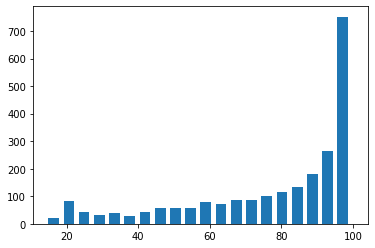

In [59]:
plt.hist(df_test["max_ident"].loc[~pd.isnull(df_test["max_ident"])], bins = 20, width= 3)
plt.show()

In [21]:
categories = ["cation", "anion", "sugar", "amino acid", "protein", "electron", "other"]

for category in categories:
    print("%s : %s"  % (category, sum(df_train[category])))

cation : 8750
anion : 869
sugar : 664
amino acid : 595
protein : 898
electron : 260
other : 1674


In [23]:
categories = ["cation", "anion", "sugar", "amino acid", "protein", "electron", "other"]

for category in categories:
    print("%s : %s"  % (category, sum(df_test[category])))

cation : 2216
anion : 225
sugar : 133
amino acid : 157
protein : 228
electron : 46
other : 423


## 6. Clustering sequences from the training set using the cd-hit algorithm

In [2]:
df_train = pd.read_pickle(join("..", "..", "data", "substrate_classes",  "df_train.pkl"))

#### (a) Getting input for cd-hit algorithm:

In [3]:
df_Uniprot = pd.DataFrame({"Sequence" : df_train["Sequence"]})
df_Uniprot.drop_duplicates(inplace = True)
df_Uniprot.reset_index(inplace = True, drop = True)
df_Uniprot

,Sequence
0,AAIFFAGTPILESAMVYPLAICGACILTSIAGTFFVKLGTNNSIMG...
1,AAWYIKGRLVPGAAYAVYSVWPLLLLLLALPPRAYAMDREMAASCG...
2,ADNQHPTVYQKVASQMHLSSSLSQDVHARYGGIQRPALSQRRFPYG...
3,AEVLMDFPQLTMTLPDGREESVMKLTTLVA
4,AEVPMPLRQLTMTLPDGREESVMERTTLVA
...,...
13705,VSAVAHRIPCQDMPPTLIRTNRFTSSFQGIVDAYGVGRYREVNPAP...
13706,VSYLAGCGLQSCPMLVAKGYPDIGWNPCGGERYLDFLRFAVFVNGE...
13707,WGEQEASILVPGDIVSIKLGDIVPADARIDQSGLTGESLPVTKNPG...
13708,WIIPFIPLPVPILIGAGLILFPTATKSFRRMWAFQSVLLLSIVMIF...


In [4]:
try:
    os.mkdir(join("..", "..", "data", "proteins", 'clusters_substrate_classes'))
except FileExistsError:
    pass

ofile = open(join("..", "..", "data", "proteins", 'clusters_substrate_classes', "all_train_sequences_substrate_classes.fasta"), "w")
for ind in df_Uniprot.index:
    seq = df_Uniprot["Sequence"][ind]
    if not pd.isnull(seq):
        seq_end = seq.find("#")
        seq = seq[:seq_end]
        ofile.write(">" + str(ind) + "\n" + seq  + "\n")
ofile.close()

In [7]:
df_Uniprot

# cluster the fasta files
cluster_folder = join("..", "..", "data", "proteins", 'clusters_substrate_classes')
start_folder = cluster_folder
cluster_all_levels_60(start_folder, 
                   cluster_folder, 
                   filename='all_train_sequences_substrate_classes')

cd-hit -i ..\..\data\proteins\clusters_substrate_classes\all_train_sequences_substrate_classes.fasta -o ..\..\data\proteins\clusters_substrate_classes\all_train_sequences_substrate_classes_clustered_sequences_100.fasta -c 1.0 -n 5 -T 1 -M 2000 -d 0
cd-hit -i ..\..\data\proteins\clusters_substrate_classes\all_train_sequences_substrate_classes_clustered_sequences_100.fasta -o ..\..\data\proteins\clusters_substrate_classes\all_train_sequences_substrate_classes_clustered_sequences_90.fasta -c 0.9 -n 5 -T 1 -M 2000 -d 0
cd-hit -i ..\..\data\proteins\clusters_substrate_classes\all_train_sequences_substrate_classes_clustered_sequences_90.fasta -o ..\..\data\proteins\clusters_substrate_classes\all_train_sequences_substrate_classes_clustered_sequences_80.fasta -c 0.8 -n 5 -T 1 -M 2000 -d 0
cd-hit -i ..\..\data\proteins\clusters_substrate_classes\all_train_sequences_substrate_classes_clustered_sequences_80.fasta -o ..\..\data\proteins\clusters_substrate_classes\all_train_sequences_substrate_clas

In [8]:
###We first cluster in such a way that two different clusters do not contain two enzymes
###with a sequence identity higher than 80%:

# collect cluster members
df_90 = find_cluster_members_90(folder=cluster_folder, 
                          filename='all_train_sequences_substrate_classes')

display(df_90.describe())
display(df_90.head())
display(df_90.tail())


# collect cluster members
df_80 = find_cluster_members_80(folder=cluster_folder, 
                          filename='all_train_sequences_substrate_classes')

display(df_80.describe())
display(df_80.head())
display(df_80.tail())


# collect cluster members
df_70 = find_cluster_members_70(folder=cluster_folder, 
                          filename='all_train_sequences_substrate_classes')


# collect cluster members
df_60 = find_cluster_members_60(folder=cluster_folder, 
                          filename='all_train_sequences_substrate_classes')


display(df_60.describe())
display(df_60.head())
display(df_60.tail())

,cluster
count,13710.000000
mean,5189.429395
std,2999.747748
min,0.000000
25%,2697.250000
50%,5032.500000
75%,7872.750000
max,10404.000000


,cluster,member
0,0,573
1,1,391
2,2,389
3,3,390
4,4,354


,cluster,member
13705,10400,58
13706,10401,2359
13707,10402,11016
13708,10403,4
13709,10404,8587


,cluster
count,13710.000000
mean,4453.102553
std,2563.194196
min,0.000000
25%,2371.250000
50%,4271.000000
75%,6809.750000
max,8905.000000


,cluster,member
0,0,573
1,0,389
2,1,391
3,2,390
4,3,354


,cluster,member
13705,8901,9310
13706,8902,58
13707,8903,2359
13708,8904,11016
13709,8905,8587


,cluster
count,13710.000000
mean,3304.934865
std,1974.619017
min,0.000000
25%,1604.250000
50%,3166.500000
75%,5177.750000
max,6746.000000


,cluster,member
0,0,573
1,0,354
2,0,391
3,0,389
4,1,390


,cluster,member
13705,6742,3838
13706,6743,9310
13707,6744,2359
13708,6745,11016
13709,6746,8587


In [11]:
df_Uniprot["cluster"] = np.nan
for ind in df_60.index:
    member = int(df_60["member"][ind])
    cluster = df_60["cluster"][ind]
    df_Uniprot["cluster"][member] = cluster

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [16]:
df_train["cluster"] = np.nan
for ind in df_train.index:
    seq = df_train["Sequence"][ind]
    cluster = list(df_Uniprot["cluster"].loc[df_Uniprot["Sequence"] == seq])[0]
    df_train["cluster"][ind] = cluster

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


#### (b) Splitting the training set into 5 folds in such a way that no sequence pair (from two different folds) has a pairwise seqeunce identity >60%

In [19]:
all_clusters_train = list(set(df_train["cluster"]))
random.shuffle(all_clusters_train)
n = len(all_clusters_train)
k = int(n/5)
clusters_fold1, clusters_fold2, clusters_fold3 = all_clusters_train[:k], all_clusters_train[k:k*2], all_clusters_train[k*2:k*3]
clusters_fold4, clusters_fold5= all_clusters_train[k*3:4*k], all_clusters_train[4*k:]

fold_indices = [list(df_train.loc[df_train["cluster"].isin(clusters_fold1)].index),
                list(df_train.loc[df_train["cluster"].isin(clusters_fold2)].index),
                list(df_train.loc[df_train["cluster"].isin(clusters_fold3)].index),
                list(df_train.loc[df_train["cluster"].isin(clusters_fold4)].index),
                list(df_train.loc[df_train["cluster"].isin(clusters_fold5)].index)]



train_indices = [[], [], [], [], []]
test_indices = [[], [], [], [], []]

for i in range(5):
    for j in range(5):
        if i != j:
            train_indices[i] = train_indices[i] + fold_indices[j]
            
    test_indices[i] = fold_indices[i]
    
    
np.save(join("..", "..", "data", "substrate_classes", "splits", "CV_train_indices_categories.npy"), train_indices)
np.save(join("..", "..", "data", "substrate_classes", "splits", "CV_test_indices_categories.npy"), test_indices)

C:\Users\alexk\anaconda3\envs\Transport\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [24]:
df_train.to_pickle(join("..", "..", "data", "substrate_classes",  "df_train.pkl")) 